source link : https://affine.medium.com/natural-language-inferencing-nli-task-demonstration-using-kaggle-dataset-34cbce0f0852

# Load XLM-RoBERTa

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import torch

In [2]:
xlmr = AutoModelForSequenceClassification.from_pretrained('joeddav/xlm-roberta-large-xnli')

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

# Load training dataset

In [4]:
train_data = pd.read_csv("../data/train.csv")
train_data.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0


# XLM-R model classes
Before going further do a sanity check to confirm if the model classes notation and the dataset classes notation is same

In [5]:
xlmr.config.label2id

{'contradiction': 0, 'entailment': 2, 'neutral': 1}

We can see that the model classes notation and Kaggle dataset classes notation (entailment (0), neutral (1), and contradiction (2)) is different. Therefore, change the training dataset classes notation to match with model.

# Change training dataset classes notation

In [6]:
train_data['label'] = train_data['label'].replace([0, 2], [2, 0])
train_data.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,2
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,0
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,2


# EDA on dataset
Check the distribution of training data based on language

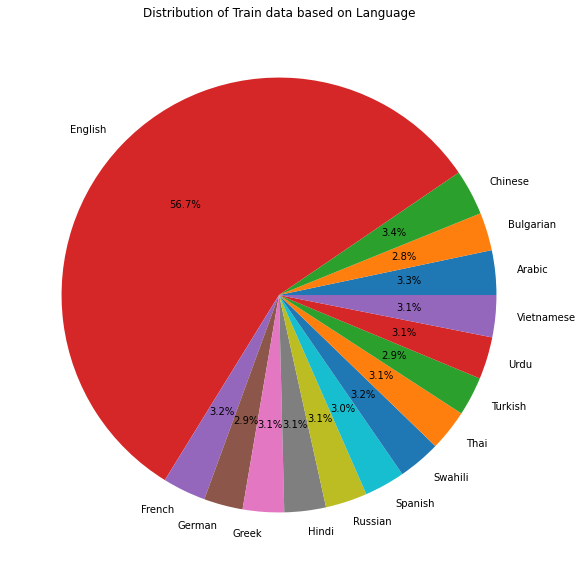

In [7]:
train_data_lang = train_data.groupby('language').count().reset_index()[['language', 'id']]

# plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(train_data_lang['id'], labels=train_data_lang['language'], autopct='%1.1f%%')
plt.title('Distribution of Train data based on Language')
plt.show()

We can see that English constitutes to more than 50% of the training data.

# Sample data creation
Since training data has 12120 textual pairs, evaluating all the pairs would be time-consuming. Therefore, we will create a sample data out of training data which will be a representative sampling ie. sample data created will have the same distribution of text pairs based on language as of the training data.

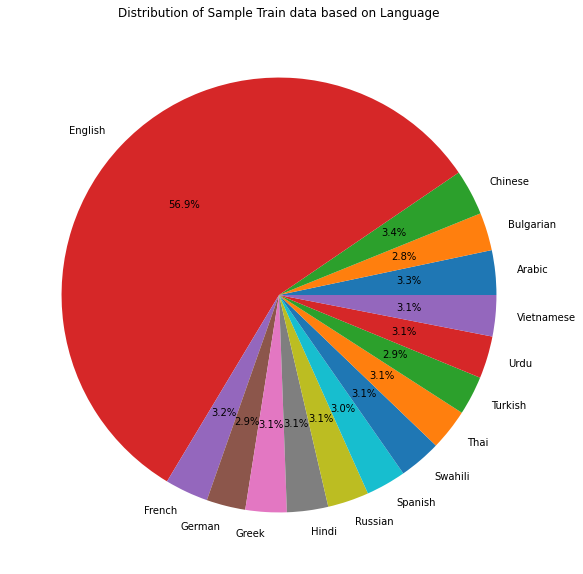

In [8]:
# create a column which tells how many random rows should be extracted for each language
train_data_lang['sample_count'] = train_data_lang['id'] / 10

# sample data
sample_train_data = pd.DataFrame(columns=train_data.columns)
for i in range(len(train_data_lang)):
    df = train_data[train_data['language'] == train_data_lang['language'][i]]
    n = int(train_data_lang['sample_count'][i])
    df = df.sample(n).reset_index(drop=True)
    sample_train_data = sample_train_data.append(df)
    sample_train_data = sample_train_data.reset_index(drop=True)

# plot distribution of sample data based on language
sample_train_data_lang = sample_train_data.groupby('language').count().reset_index()[['language', 'id']]
plt.figure(figsize=(10, 10))
plt.pie(sample_train_data_lang['id'], labels=sample_train_data_lang['language'], autopct='%1.1f%%')
plt.title('Distribution of Sample Train data based on Language')
plt.show()

We can see that sample data created and the training data have nearly same distribution of text pairs based on language.

# Functions to get predictions from XLM-R model

In [9]:
def get_tokens_xlmr_model(data):
    """ Function which creates tokens for the passed data using XLM-R model
    input — Dataframe
    Output — list of tokens """
    batch_tokens = []
    for i in range(len(data)):
        tokens = tokenizer.encode(data['premise'][i], data['hypothesis'][i], return_tensors='pt',
                                  truncation='only_first')
        batch_tokens.append(tokens)
    return batch_tokens

In [10]:
def get_predicts_xlmr_model(tokens):
    """ Function which creates predictions for the passed tokens using XLM-R model
    input — list of tokens
    Output — list of predictions """
    batch_predicts = []
    for i in tokens:
        predict = xlmr(i)[0][0]
        predict = int(predict.argmax())
        batch_predicts.append(predict)
    return batch_predicts

In [11]:
sample_train_data_tokens = get_tokens_xlmr_model(sample_train_data)
sample_train_data_predictions = get_predicts_xlmr_model(sample_train_data_tokens)

# Find model accuracy on the predictions

Classification report : 
                precision    recall  f1-score   support

contradiction       0.95      0.92      0.93       395
      neutral       0.90      0.90      0.90       402
   entailment       0.92      0.96      0.94       411

     accuracy                           0.93      1208
    macro avg       0.93      0.93      0.93      1208
 weighted avg       0.93      0.93      0.93      1208



/tmp/ipykernel_194130/3600761344.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(cm, [x, y], 1)


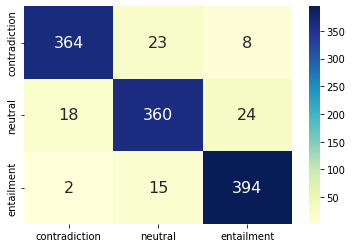

In [12]:
# plot the confusion matrix and classification report for original labels to the predicted labels
sample_train_data['label'] = sample_train_data['label'].astype(str).astype(int)
x = np.array(sample_train_data['label'])
y = np.array(sample_train_data_predictions)
cm = np.zeros((3, 3), dtype=int)
np.add.at(cm, [x, y], 1)
sns.heatmap(cm, cmap="YlGnBu", annot=True, annot_kws={'size': 16}, fmt='g',
            xticklabels=['contradiction', 'neutral', 'entailment'],
            yticklabels=['contradiction', 'neutral', 'entailment'])
matrix = classification_report(x, y, labels=[0, 1, 2], target_names=['contradiction', 'neutral', 'entailment'])
print('Classification report : \n', matrix)

The model is able to give 93% accuracy on the sample data without any finetuning.

# Find model accuracy at language level

In [13]:
sample_train_data['prediction'] = sample_train_data_predictions
sample_train_data['true_prediction'] = np.where(sample_train_data['label']==sample_train_data['prediction'], 1, 0)
sample_train_data_predicted_lang = sample_train_data.groupby('language').agg({'id':'count', 'true_prediction':'sum'}).reset_index()[['language','id','true_prediction']]
sample_train_data_predicted_lang['accuracy'] = round(sample_train_data_predicted_lang['true_prediction']/sample_train_data_predicted_lang['id'], 2)
sample_train_data_predicted_lang = sample_train_data_predicted_lang.sort_values(by=['accuracy'],ascending=False)
sample_train_data_predicted_lang

,language,id,true_prediction,accuracy
0,Arabic,40,40,1.00
1,Bulgarian,34,34,1.00
2,Chinese,41,41,1.00
4,French,39,39,1.00
8,Russian,37,37,1.00
12,Turkish,35,35,1.00
14,Vietnamese,37,37,1.00
5,German,35,34,0.97
6,Greek,37,36,0.97
7,Hindi,37,36,0.97


Except for English, the rest of the languages are having accuracy greater than 94%. Therefore, use a different model for English pairs prediction to further improve accuracy.

In [16]:
sample_train_data

,id,premise,hypothesis,lang_abv,language,label,prediction,true_prediction
0,54536f82c6,العضو الثالث من الثالوث الهندوسي هو براهما، وم...,براهما هو جزء من الثالوث الهندوسي.,ar,Arabic,2,2,1
1,04f7eac592,عملت عيادة الممارسة المدنية لدينا لعدة سنوات، ...,تعمل عيادة الممارسة المدنية منذ أكثر من عام.,ar,Arabic,2,2,1
2,e9f64ae055,وودوارد هو أفضل مظهر من المحتمل أن نحصل عليه ف...,لدى وودوارد نظرة ثاقبة في حياة كولين باول الشخ...,ar,Arabic,1,1,1
3,507248cd6c,ما هو التحدي الأكبر؟,نحن لا نتلقّى أيّ برنامج لأكبر.,ar,Arabic,0,0,1
4,dff62f5e20,بالتأكيد، كان هناك سبب جيد للاعتقاد بأن الحكوم...,.الحكومة أرادت ممات الملك,ar,Arabic,1,1,1
...,...,...,...,...,...,...,...,...
1203,2c45fa72a2,Tự do khỏi lỗi trong dữ liệu.,Tự do từ đầu vào không chính xác.,vi,Vietnamese,1,1,1
1204,7758f0be52,Hậu quả cuối cùng của sự từ chức của Livingsto...,Việc từ chức của Livingston có thể đã làm cho ...,vi,Vietnamese,1,1,1
1205,f0c6c36fcc,Nhóm bảo mật thông tin thực hiện từ 8 đến 12 p...,Nhóm an ninh tiến hành nhiều khoá trong một năm.,vi,Vietnamese,2,2,1
1206,e806d12876,Có một số dự đoán về dòng tiền trên bàn làm vi...,Chúng tôi không có bất kỳ khách hàng nào là Cu...,vi,Vietnamese,0,0,1


# RoBERTa model for English text pairs prediction

In [14]:
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')
roberta.eval()

Using cache found in /home/legmint/.cache/torch/hub/pytorch_fairseq_main
2021-12-28 12:46:23 | INFO | fairseq.file_utils | http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.mnli.tar.gz not found in cache, downloading to /tmp/tmpzsny05v1
100%|██████████| 751652118/751652118 [19:10<00:00, 653381.32B/s] 
2021-12-28 13:05:34 | INFO | fairseq.file_utils | copying /tmp/tmpzsny05v1 to cache at /home/legmint/.cache/torch/pytorch_fairseq/7685ba8546f9a5ce1a00c7a6d7d44f7e748d22681172f0f391c3d48f487c801c.74e37d47306b3cc51c5f8d335022a392c29f1906c8cd9e9cd3446d7422cf55d8
2021-12-28 13:05:35 | INFO | fairseq.file_utils | creating metadata file for /home/legmint/.cache/torch/pytorch_fairseq/7685ba8546f9a5ce1a00c7a6d7d44f7e748d22681172f0f391c3d48f487c801c.74e37d47306b3cc51c5f8d335022a392c29f1906c8cd9e9cd3446d7422cf55d8
2021-12-28 13:05:35 | INFO | fairseq.file_utils | removing temp file /tmp/tmpzsny05v1
2021-12-28 13:05:35 | INFO | fairseq.file_utils | loading archive file http://dl.fbaipublicf

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dr

RoBERTa model classes notation is same as XLM-R model notations. Therefore, we can directly use the sample data without any class notation changes.

# Extract only English pairs from sample data

In [15]:
sample_train_data_en = sample_train_data[sample_train_data['language']=='English'].reset_index(drop=True)
sample_train_data_en.shape

(687, 8)

# Functions to get predictions from RoBERTa model

In [16]:
def get_tokens_roberta(data):
	""" Function which generates tokens for the passed data using roberta model
	input — Dataframe
	Output — list of tokens """
	batch_tokens = []
	for i in range(len(data)):
		tokens = roberta.encode(data['premise'][i],data['hypothesis'][i])
		batch_tokens.append(tokens)
	return batch_tokens

In [17]:
def get_predictions_roberta(tokens):
	""" Function which generates predictions for the passed tokens using roberta model
	input — list of tokens
	Output — list of predictions """
	batch_predictions = []
	for i in range(len(tokens)):
		prediction = roberta.predict('mnli', tokens[i]).argmax().item()
		batch_predictions.append(prediction)
	return batch_predictions

# Predictions with RoBERTa model

In [21]:
# sample_train_data_tokens = get_tokens_xlmr_model(sample_train_data)
# sample_train_data_predictions = get_predicts_xlmr_model(sample_train_data_tokens)
sample_train_data_en_tokens = get_tokens_xlmr_model(sample_train_data_en)
sample_train_data_en_predictions = get_predicts_xlmr_model(sample_train_data_en_tokens)

#  Accuracy of RoBERTa model

In [22]:
sample_train_data_en['prediction'] = sample_train_data_en_predictions
# roberta model accuracy
sample_train_data_en['true_prediction'] = np.where(sample_train_data_en['label']==sample_train_data_en['prediction'], 1, 0)
roberta_accuracy = round(sum(sample_train_data_en['true_prediction'])/len(sample_train_data_en), 2)
print('Accuracy of RoBERTa model {}'.format(roberta_accuracy))

Accuracy of RoBERTa model 0.88


Accuracy of English text pairs increased from 89% to 92%. Therefore, for predictions on test dataset of Kaggle challenge use RoBERTa for English pairs prediction and XLM-R for predictions of other language pairs.
By this approach, I was able to score 94.167% accuracy on the test dataset.

# Conclusion

In this blog ,we have learned what NLI task is, how to achieve this using two state-of-the-art models. There are many more pre-trained models for achieving NLI tasks other than the models discussed in this blog. Few of them are language-specific like German BERT, French BERT, Finnish BERT, etc. multilingual models like Multilingual BERT, XLM-100, etc.

As future steps, one can further achieve task-specific accuracy by fine-tuning these models with specific data.